# II-3 Analyse Bi-variable

**But:** analyser les relations entre variables explicatives (X vs X) et entre Y et chaque X (X vs Y).


In [3]:
import os
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import FunctionTransformer
from sklearn.cluster import AgglomerativeClustering
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt

DATA_PATH = '../../data/raw/diabetes.csv'

if os.path.exists(DATA_PATH):
    df = pd.read_csv(DATA_PATH)
    print(f'Loaded dataset from {DATA_PATH} with shape', df.shape)
else:
    print(f'{DATA_PATH} not found — création d\'un jeu de données synthétique (exemple).')

df.head()


Loaded dataset from ../../data/raw/diabetes.csv with shape (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Numeric columns: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']

Pearson correlation matrix:
                           Pregnancies  Glucose  BloodPressure  SkinThickness  \
Pregnancies                     1.000    0.129          0.141         -0.082   
Glucose                         0.129    1.000          0.153          0.057   
BloodPressure                   0.141    0.153          1.000          0.207   
SkinThickness                  -0.082    0.057          0.207          1.000   
Insulin                        -0.074    0.331          0.089          0.437   
BMI                             0.018    0.221          0.282          0.393   
DiabetesPedigreeFunction       -0.034    0.137          0.041          0.184   
Age                             0.544    0.264          0.240         -0.114   
Outcome                         0.222    0.467          0.065          0.075   

                          I

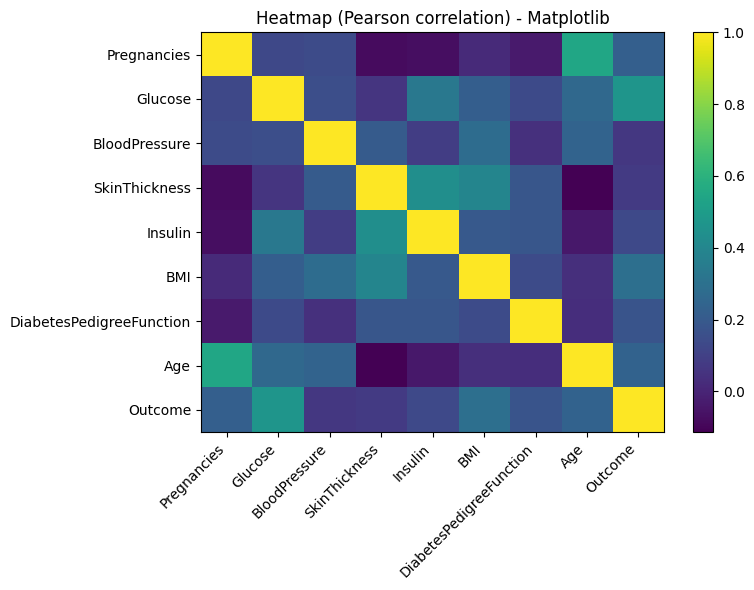

In [4]:
# 1) Matrice de corrélation (Pearson) pour toutes les variables numériques
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print('Numeric columns:', num_cols)

corr = df[num_cols].corr(method='pearson')
print('\nPearson correlation matrix:\n', corr.round(3))

# Plot heatmap with matplotlib
plt.figure(figsize=(8,6))
plt.imshow(corr.values, interpolation='nearest', aspect='auto')
plt.colorbar()
plt.xticks(range(len(num_cols)), num_cols, rotation=45, ha='right')
plt.yticks(range(len(num_cols)), num_cols)
plt.title('Heatmap (Pearson correlation) - Matplotlib')
plt.tight_layout()
plt.show()

Pairs with |corr| >= 0.5 : [('Pregnancies', 'Age', np.float64(0.5443412284023392))]


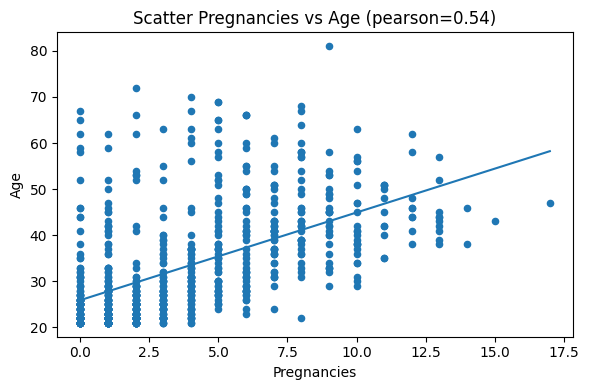

In [5]:

# 2) Visualiser la relation entre paires de variables (scatterplots + regression line)
# Example: loop through top correlated pairs (abs corr > 0.5 excluding self)
pairs = []
threshold = 0.5
for i, a in enumerate(num_cols):
    for j, b in enumerate(num_cols):
        if j <= i: continue
        if abs(corr.loc[a,b]) >= threshold:
            pairs.append((a,b,corr.loc[a,b]))

print('Pairs with |corr| >=', threshold, ':', pairs)

# If no such pairs, pick the top 4 absolute correlations
if not pairs:
    flat = []
    for i, a in enumerate(num_cols):
        for j, b in enumerate(num_cols):
            if j <= i: continue
            flat.append((a,b,abs(corr.loc[a,b])))
    flat_sorted = sorted(flat, key=lambda x: x[2], reverse=True)[:4]
    pairs = [(a,b,corr.loc[a,b]) for a,b,_ in flat_sorted]
    print('Top pairs:', pairs)

for a,b,r in pairs:
    plt.figure(figsize=(6,4))
    plt.scatter(df[a], df[b], s=20)
    # regression line using numpy polyfit
    m, c = np.polyfit(df[a], df[b], 1)
    xs = np.linspace(df[a].min(), df[a].max(), 100)
    plt.plot(xs, m*xs + c)
    plt.xlabel(a)
    plt.ylabel(b)
    plt.title(f'Scatter {a} vs {b} (pearson={r:.2f})')
    plt.tight_layout()
    plt.show()


In [6]:

# 3) Détecter relations non-linéaires et proposer transformations simples (log, sqrt)
# We'll compute Spearman correlation and compare to Pearson: if Spearman much larger => potential non-linearity
spearman = df[num_cols].corr(method='spearman')
diff = (spearman - corr).abs()

# Show top differences
diff_vals = []
for i,a in enumerate(num_cols):
    for j,b in enumerate(num_cols):
        if j <= i: continue
        diff_vals.append((a,b,diff.loc[a,b], corr.loc[a,b], spearman.loc[a,b]))
diff_sorted = sorted(diff_vals, key=lambda x: x[2], reverse=True)[:6]
print('Top pairs with largest Spearman-Pearson difference (possible non-linear relationships):')
for row in diff_sorted:
    print(row)

# Example: apply log transform to positive skewed variables and re-check Pearson with Outcome
to_try = ['Insulin','Glucose','BMI']
for col in to_try:
    if (df[col] <= 0).any():
        trans = np.log1p(df[col])  # log(1+x)
    else:
        trans = np.log(df[col])
    print(f'Original pearson({col}, Outcome) =', df[col].corr(df['Outcome']))
    print(f'Log-transformed pearson(log({col}), Outcome) =', trans.corr(df['Outcome']))
    print('---')


Top pairs with largest Spearman-Pearson difference (possible non-linear relationships):
('Glucose', 'Insulin', np.float64(0.11815130535827817), np.float64(0.3313571099202092), np.float64(0.21320580456193106))
('BloodPressure', 'Age', np.float64(0.11136664680027197), np.float64(0.23952794642136344), np.float64(0.3508945932216354))
('SkinThickness', 'Insulin', np.float64(0.10421756654278819), np.float64(0.43678257012001326), np.float64(0.5410001366628014))
('BloodPressure', 'Insulin', np.float64(0.09570395018450577), np.float64(0.08893337837319314), np.float64(-0.006770571811312636))
('BMI', 'Age', np.float64(0.09494401045047476), np.float64(0.03624187009229395), np.float64(0.13118588054276872))
('Glucose', 'BloodPressure', np.float64(0.0826010269095189), np.float64(0.1525895865686646), np.float64(0.23519061347818349))
Original pearson(Insulin, Outcome) = 0.13054795488404786
Log-transformed pearson(log(Insulin), Outcome) = 0.009782533729950907
---
Original pearson(Glucose, Outcome) = 0.4

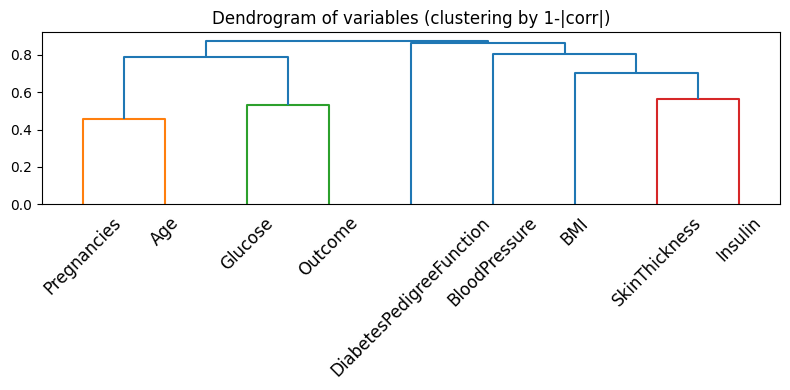

Clusters for k=2: {np.int64(1): ['Pregnancies', 'Glucose', 'Age', 'Outcome'], np.int64(0): ['BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction']}
Clusters for k=3: {np.int64(1): ['Pregnancies', 'Glucose', 'Age', 'Outcome'], np.int64(0): ['BloodPressure', 'SkinThickness', 'Insulin', 'BMI'], np.int64(2): ['DiabetesPedigreeFunction']}
Clusters for k=4: {np.int64(0): ['Pregnancies', 'Glucose', 'Age', 'Outcome'], np.int64(3): ['BloodPressure'], np.int64(1): ['SkinThickness', 'Insulin', 'BMI'], np.int64(2): ['DiabetesPedigreeFunction']}


In [10]:

# 4) Analyser s'il y a des sous-groupes de variables explicatives (clustering des variables)
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram

# Distance between variables = 1 - abs(correlation)
dist = 1 - np.abs(corr.values)
# Ensure zero diagonal
np.fill_diagonal(dist, 0)
# Condensed distance for linkage
condensed = squareform(dist, checks=False)

Z = linkage(condensed, method='average')
plt.figure(figsize=(8,4))
dn = dendrogram(Z, labels=num_cols, leaf_rotation=45)
plt.title('Dendrogram of variables (clustering by 1-|corr|)')
plt.tight_layout()
plt.show()

# Use AgglomerativeClustering to form groups (e.g., 2-4 clusters) and print groups
for k in [2,3,4]:
    model = AgglomerativeClustering(n_clusters=k, metric='precomputed', linkage='average')
    # AgglomerativeClustering with precomputed requires a distance matrix
    labels = model.fit_predict(dist)
    groups = {}
    for var, lab in zip(num_cols, labels):
        groups.setdefault(lab, []).append(var)
    print(f'Clusters for k={k}:', groups)


In [11]:

# II-3-2 : Entre Y (Outcome) et X
print('\n---\nAnalyses entre Y (Outcome) et chaque X:\n')

y = 'Outcome'
results = []
for col in num_cols:
    if col == y: 
        continue
    # Pearson for numeric vs binary: Pearson can be computed but interpret with care
    pear = df[col].corr(df[y])
    # t-test: split by outcome
    grp0 = df[df[y]==0][col].dropna()
    grp1 = df[df[y]==1][col].dropna()
    # Student t-test (independent)
    try:
        tstat, pval = stats.ttest_ind(grp0, grp1, equal_var=False, nan_policy='omit')
    except Exception as e:
        tstat, pval = (np.nan, np.nan)
    results.append((col, pear, tstat, pval, len(grp0), len(grp1)))

import pandas as pd
res_df = pd.DataFrame(results, columns=['feature','pearson_with_Y','t_stat','t_pvalue','n_group0','n_group1'])
display(res_df.sort_values('pearson_with_Y', key=abs, ascending=False))

# ANOVA example for a categorical transformation:
# If we create an age_group categorical, we can perform ANOVA for a numeric variable
df['age_group'] = pd.cut(df['Age'], bins=[20,30,40,50,100], labels=['20-30','30-40','40-50','50+'])
groups = [df[df['age_group']==g]['Glucose'].dropna() for g in df['age_group'].cat.categories]
fstat, pval_anova = stats.f_oneway(*groups)
print('\nANOVA Glucose ~ age_group: F=', fstat, ', p=', pval_anova)



---
Analyses entre Y (Outcome) et chaque X:



,feature,pearson_with_Y,t_stat,t_pvalue,n_group0,n_group1
1,Glucose,0.466581,-13.751537,2.644161e-36,500,268
5,BMI,0.292695,-8.619317,6.566238e-17,500,268
7,Age,0.238356,-6.920738,1.201513e-11,500,268
0,Pregnancies,0.221898,-5.906961,6.821926e-09,500,268
6,DiabetesPedigreeFunction,0.173844,-4.576812,6.100481e-06,500,268
4,Insulin,0.130548,-3.300895,1.046929e-03,500,268
3,SkinThickness,0.074752,-1.970579,4.935586e-02,500,268
2,BloodPressure,0.065068,-1.713087,8.735425e-02,500,268



ANOVA Glucose ~ age_group: F= 18.68395633058157 , p= 1.0546212014806983e-11
